In [12]:
# ======================
# Setup + Safe Helpers
# ======================
import sys, re, warnings, math
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score, brier_score_loss
)
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.impute import SimpleImputer
from packaging import version

warnings.filterwarnings("ignore")

print("="*70)
print("SMU Wellness — Visual EDA + Feature Engineering + Baseline Model")
print("This notebook keeps duplicates, adds visuals, clear printouts, and")
print("handles common errors (missing columns, package versions, NaNs).")
print("="*70)

# --------------- sklearn compatibility helpers ----------------
SKL = None
try:
    import sklearn
    SKL = sklearn.__version__
    print(f"[info] scikit-learn version: {SKL}")
except Exception as e:
    print("[warn] Could not detect scikit-learn version:", e)

def make_onehot_encoder():
    """Return an OneHotEncoder that works across sklearn versions."""
    try:
        # sklearn >= 1.2 supports sparse_output
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        # older versions use sparse=
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

def make_calibrator(estimator, method="isotonic", cv=3):
    """Return CalibratedClassifierCV that works for old/new sklearn APIs."""
    try:
        # new API (>=1.4) uses 'estimator='
        return CalibratedClassifierCV(estimator=estimator, method=method, cv=cv)
    except TypeError:
        # older API uses 'base_estimator='
        return CalibratedClassifierCV(base_estimator=estimator, method=method, cv=cv)

# --------------- plotting niceties ----------------
def annotate_bars(ax):
    """Add value labels above bars."""
    for p in ax.patches:
        try:
            val = p.get_height()
        except Exception:
            val = p.get_width()
        if pd.notna(val) and val != 0:
            ax.annotate(f"{int(val)}", (p.get_x()+p.get_width()/2, val),
                        ha='center', va='bottom', fontsize=9, rotation=0)

def explain(title, note):
    """Print a short explanation above a section."""
    print(f"\n--- {title} ---")
    print(note)


SMU Wellness — Visual EDA + Feature Engineering + Baseline Model
This notebook keeps duplicates, adds visuals, clear printouts, and
handles common errors (missing columns, package versions, NaNs).
[info] scikit-learn version: 1.4.0


In [13]:
# ======================
# Load Data + Column Map
# ======================
import pandas as pd

# Load your Excel file
df = pd.read_excel('/Users/ritikabajpai/Desktop/SMU_Survey_Final.xlsx')

# Updated column maps based on actual column names in your file
KEY_COLUMNS = {
    'age': 'Age',
    'gender': 'Gender', 
    'year': 'YearOfStudy',
    'school': 'School',
    'intent_90d': 'Q27_27InTheNext90DaysHowLikelyAreYouToUseAnySmuWellnessServiceCounsellingWorkshopsEvents',
    'past_attend_count': 'Q28_28InThePast6MonthsHowManyWellnessEventsDidYouAttend',
    'no_show_count': 'Q29_29InThePast6MonthsHowManyWellnessEventsDidYouSignUpButNotAttendNoShow',
    'next_program': 'Q30_30IfYouCouldJoinExactlyOneWellnessProgramNextWhichTypeOfEventWouldYouPick',
    'preferred_format': 'Q31_31WhichFormatDoYouPreferMost',
    'preferred_time_windows': 'Q32_32WhichTimesWorkBestForYouSelectUpTo2',
    'barrier_time': 'Q33_lackOfTime',
    'barrier_cost': 'Q33_cost',
    'barrier_motivation': 'Q33_lackOfMotivationWillpower',
    'barrier_access': 'Q33_convenience',
}

RELEVANCE_COLUMNS = {
    'relevance_MHW': 'Q34_mentalHealthWeek',
    'relevance_Resilience': 'Q34_resilienceFramework',
    'relevance_ExamAngels': 'Q34_examAngels',
    'relevance_SCS': 'Q34_studentCareServices',
    'relevance_CosyHaven': 'Q34_cosyHaven',
    'relevance_Voices': 'Q34_voicesRoadshows',
    'relevance_PeerHelpers': 'Q34_peerHelpersRoadshows',
    'relevance_CareerCompass': 'Q34_careerCompass',
    'relevance_CARES': 'Q34_caresCorner'
}

use_cols = {**KEY_COLUMNS, **RELEVANCE_COLUMNS}

# Validate availability and rename to clean names
missing = [v for v in use_cols.values() if v not in df.columns]
if missing:
    raise KeyError(
        "The following expected survey columns are missing:\n"
        + "\n".join(f"- {m}" for m in missing) +
        "\nCheck the questionnaire wording/typos or update the map."
    )

data = df[list(use_cols.values())].rename(columns={v:k for k,v in use_cols.items()})
print(f"[ok] Selected {len(use_cols)} features from {len(data)} rows (duplicates retained).")


[ok] Selected 23 features from 252 rows (duplicates retained).



--- Demographics ---
Age uses a histogram; gender, year, and school are counts. Use this to confirm the sample distribution looks sensible.


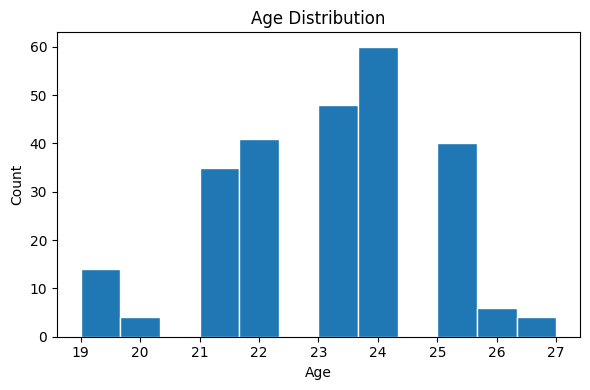

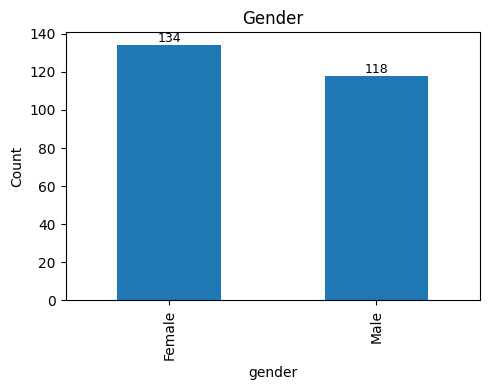

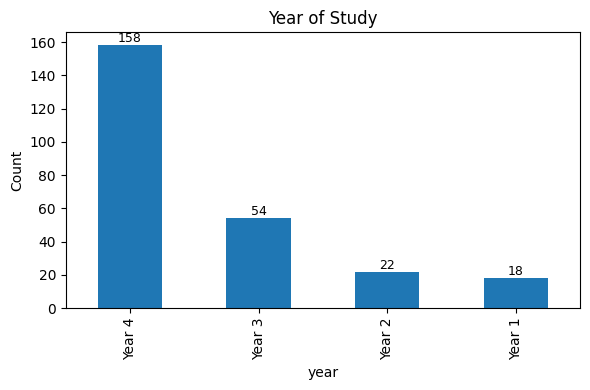

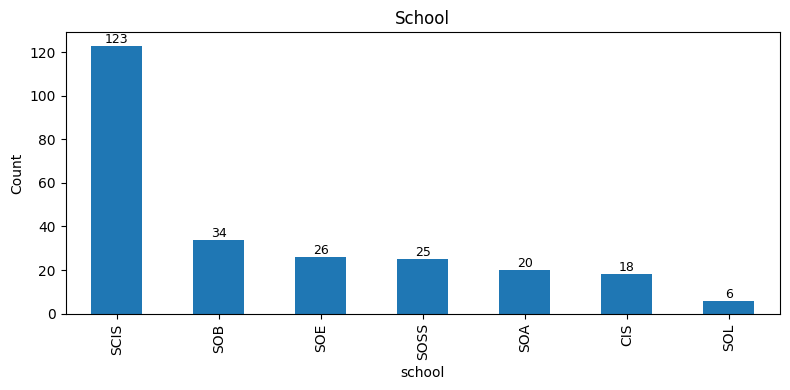


--- Intent & Behaviour ---
Intent is on a 0–10 scale (histogram). Past attendance and no-shows are categorical buckets—helpful to gauge engagement history.


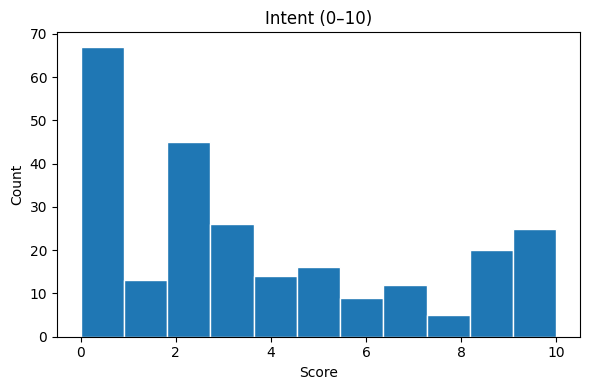

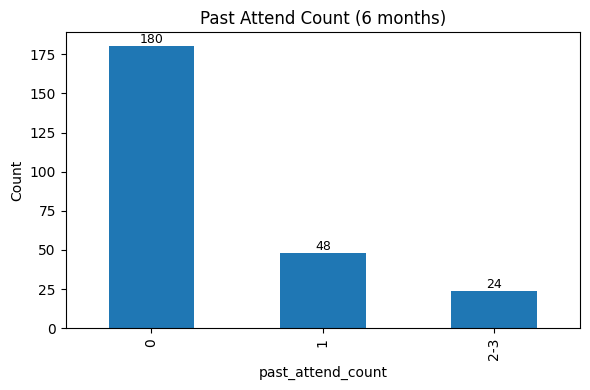

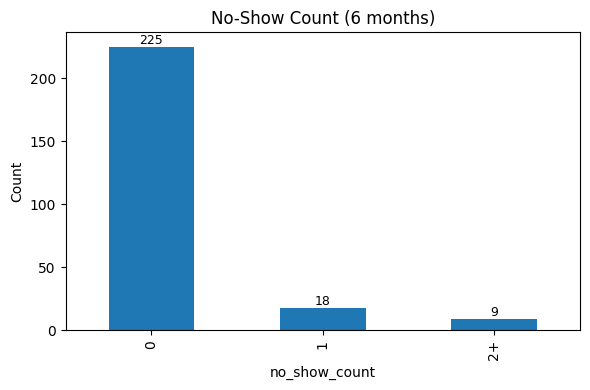


--- Preferences ---
These charts show what students say they’d pick next (program), preferred delivery format, and which time windows are most popular.


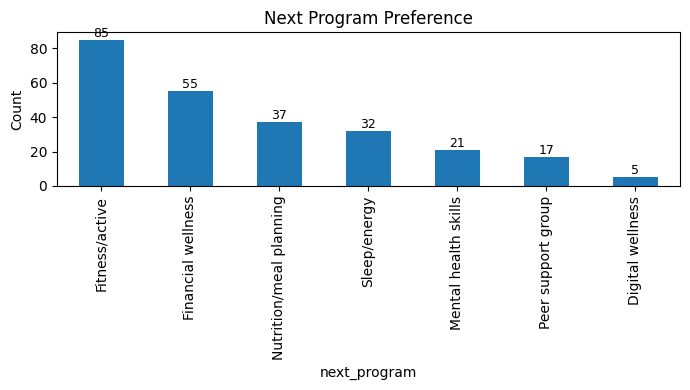

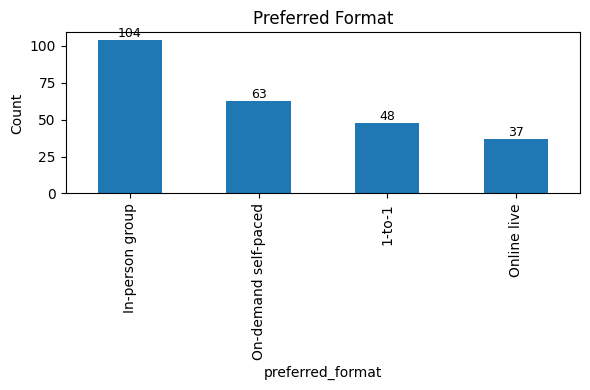

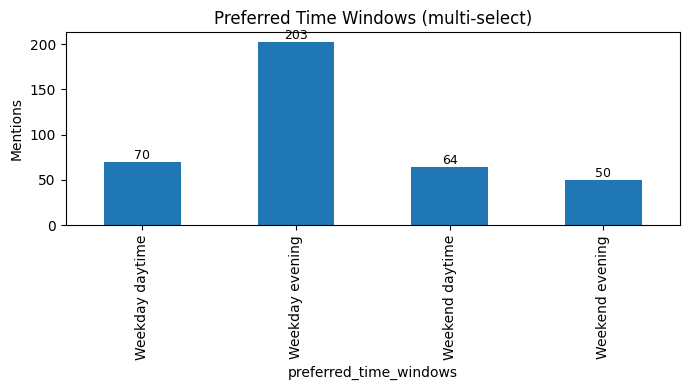


--- Barriers (0–10) ---
Higher means a larger barrier. This highlights what mainly stops students (e.g., time vs motivation).


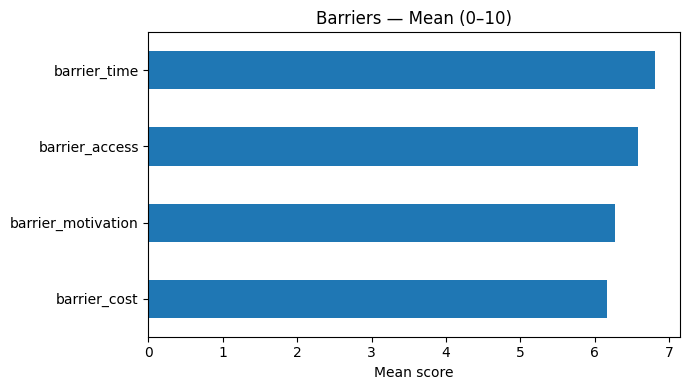


--- Initiatives relevance (1–10) ---
Which schemes feel most relevant right now? Use this to align programming and communications with perceived needs.


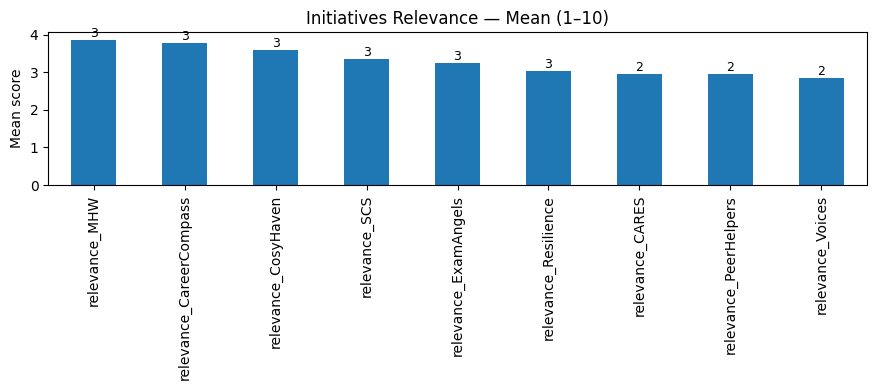


--- Correlation (numeric only) ---
Blue=negative, yellow=positive. Use this to spot simple linear relationships (e.g., intent vs barriers). Not causal, just association.


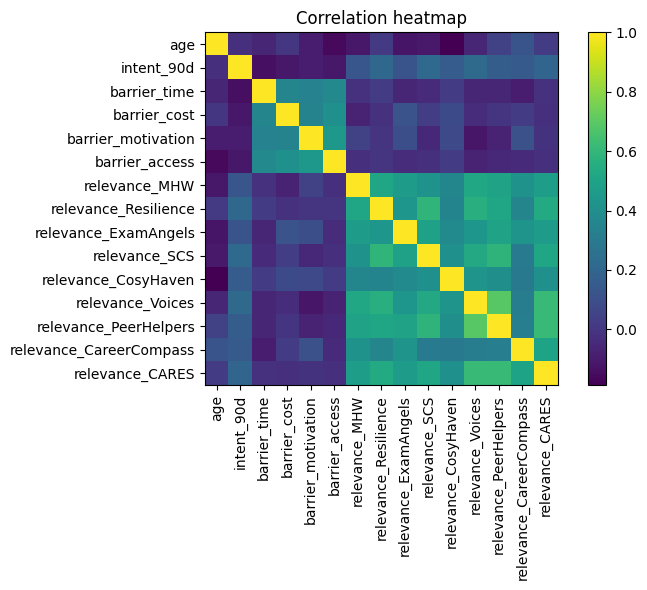

In [14]:
# ======================
# Visual EDA
# ======================
explain("Demographics", 
        "Age uses a histogram; gender, year, and school are counts. "
        "Use this to confirm the sample distribution looks sensible.")

# Age
plt.figure(figsize=(6,4))
data['age'].dropna().astype(float).plot(kind='hist', bins=12, edgecolor='white')
plt.title('Age Distribution'); plt.xlabel('Age'); plt.ylabel('Count'); plt.tight_layout()
plt.show()

# Gender
plt.figure(figsize=(5,4))
ax = data['gender'].astype(str).str.strip().value_counts().plot(kind='bar')
plt.title('Gender'); plt.ylabel('Count'); annotate_bars(ax); plt.tight_layout(); plt.show()

# Year
plt.figure(figsize=(6,4))
ax = data['year'].astype(str).str.strip().value_counts().plot(kind='bar')
plt.title('Year of Study'); plt.ylabel('Count'); annotate_bars(ax); plt.tight_layout(); plt.show()

# School
plt.figure(figsize=(8,4))
ax = data['school'].astype(str).str.strip().value_counts().plot(kind='bar')
plt.title('School'); plt.ylabel('Count'); annotate_bars(ax); plt.tight_layout(); plt.show()

# Intent + behaviour
explain("Intent & Behaviour", 
        "Intent is on a 0–10 scale (histogram). Past attendance and no-shows "
        "are categorical buckets—helpful to gauge engagement history.")

plt.figure(figsize=(6,4))
data['intent_90d'].dropna().plot(kind='hist', bins=11, edgecolor='white')
plt.title('Intent (0–10)'); plt.xlabel('Score'); plt.ylabel('Count'); plt.tight_layout(); plt.show()

for col, title in [('past_attend_count','Past Attend Count (6 months)'),
                   ('no_show_count','No-Show Count (6 months)')]:
    plt.figure(figsize=(6,4))
    ax = data[col].astype(str).str.strip().value_counts().plot(kind='bar')
    plt.title(title); plt.ylabel('Count'); annotate_bars(ax); plt.tight_layout(); plt.show()

# Preferences
explain("Preferences", 
        "These charts show what students say they’d pick next (program), "
        "preferred delivery format, and which time windows are most popular.")

plt.figure(figsize=(7,4))
ax = data['next_program'].astype(str).str.strip().value_counts().plot(kind='bar')
plt.title('Next Program Preference'); plt.ylabel('Count'); annotate_bars(ax); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
ax = data['preferred_format'].astype(str).str.strip().value_counts().plot(kind='bar')
plt.title('Preferred Format'); plt.ylabel('Count'); annotate_bars(ax); plt.tight_layout(); plt.show()

# Multi-select time windows
def multi_hot_counts(series, choices):
    s = (series.fillna('')
               .astype(str)
               .str.replace(r'\s*[/;]\s*', ', ', regex=True))
    exploded = s.str.split(',').explode().str.strip()
    exploded = exploded[exploded.ne('')]
    return exploded.value_counts().reindex(choices, fill_value=0)

time_choices = ['Weekday daytime','Weekday evening','Weekend daytime','Weekend evening']
plt.figure(figsize=(7,4))
ax = multi_hot_counts(data['preferred_time_windows'], time_choices).plot(kind='bar')
plt.title('Preferred Time Windows (multi-select)'); plt.ylabel('Mentions'); annotate_bars(ax); plt.tight_layout(); plt.show()

# Barriers
explain("Barriers (0–10)", 
        "Higher means a larger barrier. This highlights what mainly stops students "
        "(e.g., time vs motivation).")

barrier_cols = ['barrier_time','barrier_cost','barrier_motivation','barrier_access']
means = data[barrier_cols].apply(pd.to_numeric, errors='coerce').mean().sort_values()
plt.figure(figsize=(7,4))
ax = means.plot(kind='barh')
plt.title('Barriers — Mean (0–10)'); plt.xlabel('Mean score'); plt.tight_layout(); plt.show()

# Relevance of initiatives
explain("Initiatives relevance (1–10)", 
        "Which schemes feel most relevant right now? Use this to align programming "
        "and communications with perceived needs.")

rel_cols = [c for c in data.columns if c.startswith('relevance_')]
rel_means = data[rel_cols].apply(pd.to_numeric, errors='coerce').mean().sort_values(ascending=False)
plt.figure(figsize=(9,4))
ax = rel_means.plot(kind='bar')
plt.title('Initiatives Relevance — Mean (1–10)'); plt.ylabel('Mean score'); annotate_bars(ax); plt.tight_layout(); plt.show()

# Correlations
explain("Correlation (numeric only)", 
        "Blue=negative, yellow=positive. Use this to spot simple linear relationships "
        "(e.g., intent vs barriers). Not causal, just association.")
num_cols = ['age','intent_90d'] + barrier_cols + rel_cols
corr = data[num_cols].apply(pd.to_numeric, errors='coerce').corr()
plt.figure(figsize=(8,6))
plt.imshow(corr, interpolation='nearest')
plt.colorbar(); plt.xticks(range(len(corr)), corr.columns, rotation=90); plt.yticks(range(len(corr)), corr.index)
plt.title('Correlation heatmap'); plt.tight_layout(); plt.show()



=== Feature engineering ===
- ordinals: past_attend_count→0/1/2/3; no_show_count→0/1/2
- scaled numerics: intent/10, barriers/10, max relevance/10
- multi-hot: preferred_time_windows (4 binaries)
- one-hot: next_program, preferred_format, school, gender
- derived indices: barrier_index, scheme_relevance_max

=== Data dictionary (compact) ===
Numeric (scaled/ordinal + raw): 19
One-hot categories: ['next_program', 'preferred_format', 'school', 'gender']
Binary time-window flags: ['time_weekday_daytime', 'time_weekday_evening', 'time_weekend_daytime', 'time_weekend_evening']
Tip: Missing numeric values will be median-imputed; categorical = mode.

=== Proxy label ===
We temporarily label y=1 if intent_90d ≥ 7.
Class balance → positives=62 (24.6%), negatives=190 (75.4%).
We set class_weight='balanced' so both classes are considered fairly.
[split] train=176, valid=38, test=38

=== Calibration ===
We wrap Logistic Regression with isotonic calibration so predicted probabilities behave like r

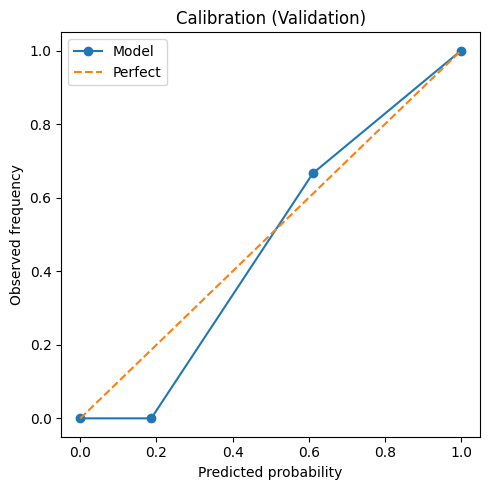

If the blue dots hug the dashed line, your probabilities are well-calibrated.

=== Driver summary skipped ===
Could not compute coefficients: '_CalibratedClassifier' object has no attribute 'coef_'


In [15]:
# ==============================================
# Feature Engineering + Calibrated Logistic Reg
# (Verbose, explain-as-you-go version)
# ==============================================
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score, brier_score_loss,
    precision_recall_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.impute import SimpleImputer

def _make_onehot_encoder():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

def _make_calibrator(estimator, method="isotonic", cv=3):
    try:
        return CalibratedClassifierCV(estimator=estimator, method=method, cv=cv)
    except TypeError:
        return CalibratedClassifierCV(base_estimator=estimator, method=method, cv=cv)

def _say(title, text):
    print(f"\n=== {title} ===")
    print(text)

# 1) Build engineered table exactly per spec
_say("Feature engineering",
    "- ordinals: past_attend_count→0/1/2/3; no_show_count→0/1/2\n"
    "- scaled numerics: intent/10, barriers/10, max relevance/10\n"
    "- multi-hot: preferred_time_windows (4 binaries)\n"
    "- one-hot: next_program, preferred_format, school, gender\n"
    "- derived indices: barrier_index, scheme_relevance_max")

def map_past(x):
    s = str(x).strip()
    if s in ['0','Zero','zero']: return 0
    if s in ['1','One','one']: return 1
    if '2-3' in s or '2 – 3' in s or '2 to 3' in s: return 2
    if '4+' in s or '4 +' in s or '4 or more' in s: return 3
    try:
        n = int(float(s))
        if n<=0: return 0
        if n==1: return 1
        if 2<=n<=3: return 2
        return 3
    except: return np.nan

def map_noshow(x):
    s = str(x).strip()
    if s in ['0','Zero','zero']: return 0
    if s in ['1','One','one']: return 1
    if '2+' in s or '2 +' in s or '2 or more' in s: return 2
    try:
        n = int(float(s))
        if n<=0: return 0
        if n==1: return 1
        return 2
    except: return np.nan

X = data.copy()
barrier_cols = ['barrier_time','barrier_cost','barrier_motivation','barrier_access']
rel_cols = [c for c in X.columns if c.startswith('relevance_')]

# Ordinals
X['past_attend_ord'] = X['past_attend_count'].map(map_past)
X['no_show_ord']     = X['no_show_count'].map(map_noshow)

# Scaled numerics & indices
X['intent_scaled']        = pd.to_numeric(X['intent_90d'], errors='coerce')/10.0
X['barrier_index']        = X[barrier_cols].apply(pd.to_numeric, errors='coerce').mean(axis=1)/10.0
X['scheme_relevance_max'] = X[rel_cols].apply(pd.to_numeric, errors='coerce').max(axis=1)/10.0

# Multi-hot: preferred time windows
time_choices = ['Weekday daytime','Weekday evening','Weekend daytime','Weekend evening']
def _split_multi(val):
    if pd.isna(val): return []
    s = re.sub(r'\s*[/;]\s*', ', ', str(val))
    return [t.strip() for t in s.split(',') if t.strip()]

for t in time_choices:
    X[f'time_{t.replace(" ","_").lower()}'] = X['preferred_time_windows'].apply(lambda v: 1 if t in _split_multi(v) else 0)

# Define feature roles
num_feats = ['intent_scaled','barrier_index','scheme_relevance_max','age','past_attend_ord','no_show_ord',
             'barrier_time','barrier_cost','barrier_motivation','barrier_access'] + rel_cols
cat_onehot = ['next_program','preferred_format','school','gender']
bin_feats = [c for c in X.columns if c.startswith('time_')]

# Show a compact data dictionary
_say("Data dictionary (compact)",
    f"Numeric (scaled/ordinal + raw): {len(num_feats)}\n"
    f"One-hot categories: {cat_onehot}\n"
    f"Binary time-window flags: {bin_feats}\n"
    "Tip: Missing numeric values will be median-imputed; categorical = mode.")

# 2) Proxy label & class balance
y = (pd.to_numeric(X['intent_90d'], errors='coerce') >= 7).astype(int)
pos, neg = int(y.sum()), int((1-y).sum())
_say("Proxy label",
    f"We temporarily label y=1 if intent_90d ≥ 7.\n"
    f"Class balance → positives={pos} ({pos/len(y):.1%}), negatives={neg} ({neg/len(y):.1%}).\n"
    "We set class_weight='balanced' so both classes are considered fairly.")

# 3) Splits
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)
print(f"[split] train={len(X_train)}, valid={len(X_valid)}, test={len(X_test)}")

# 4) Preprocess
num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')),
                     ('scaler', StandardScaler())])
cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                     ('onehot',  _make_onehot_encoder())])

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_feats),
    ('cat', cat_pipe, cat_onehot),
    ('bin', 'passthrough', bin_feats)
], remainder='drop')

# 5) Model + calibration (with explanation)
base = LogisticRegression(max_iter=2000, class_weight='balanced')
clf  = _make_calibrator(base, method='isotonic', cv=3)

_say("Calibration",
    "We wrap Logistic Regression with isotonic calibration so predicted "
    "probabilities behave like real-world chances (e.g., 0.70 ≈ 70% attend).")

pipe = Pipeline([('prep', preprocessor), ('clf', clf)])

try:
    pipe.fit(X_train, y_train)
    print("[ok] Trained + calibrated.")
except Exception as e:
    _say("Training error",
        "Common causes:\n"
        "- Non-numeric values in numeric columns that couldn’t be coerced\n"
        "- Columns that became all-NaN after selection\n"
        "- Package version mismatch\n"
        f"Raw error: {e}")
    raise

# 6) Metrics + explanations
def _report(split, Xs, ys):
    p = pipe.predict_proba(Xs)[:,1]
    yhat = (p >= 0.5).astype(int)
    print(f"\n--- {split} metrics ---")
    print(f"AUROC : {roc_auc_score(ys, p):.3f}  → ranking quality; 0.5=chance, 1.0=perfect")
    print(f"PR-AUC: {average_precision_score(ys, p):.3f}  → precision–recall area; useful with imbalance")
    print(f"F1@0.5: {f1_score(ys, yhat):.3f}  → balance of precision & recall at 0.5 threshold")
    print(f"Brier : {brier_score_loss(ys, p):.3f}  → prob. calibration error; lower is better (≈0 best)")
    return p

p_tr = _report("Train", X_train, y_train)
p_va = _report("Valid", X_valid, y_valid)
p_te = _report("Test ", X_test,  y_test)

# 7) Recommend operational buckets on the validation set
_say("Operating policy (validation)",
    "We form three action buckets on validation predictions:\n"
    "  • LOW   : p < 0.35  → deprioritize or light-touch nudge\n"
    "  • MEDIUM: 0.35–0.70 → normal comms; consider incentives\n"
    "  • HIGH  : p ≥ 0.70  → priority invites, personalized nudges")

def bucketize(p):
    cats = pd.cut(p, bins=[-1,0.35,0.70,1.01], labels=['LOW','MED','HIGH'])
    return cats

val_buckets = bucketize(p_va)
val_summary = pd.crosstab(val_buckets, y_valid, rownames=['bucket'], colnames=['actual'])
print("\n[validation bucket vs actual]")
print(val_summary)
print("\nInterpretation:")
print("- Within HIGH, a greater share of actual 1s means your threshold is useful for targeting.")
print("- Adjust 0.35/0.70 to trade off coverage vs precision for campaigns.")

# 8) Reliability (calibration) curve – with plain-English caption
try:
    prob_true, prob_pred = [], []
    from sklearn.calibration import calibration_curve
    prob_true, prob_pred = calibration_curve(y_valid, p_va, n_bins=10, strategy='quantile')
    plt.figure(figsize=(5,5))
    plt.plot(prob_pred, prob_true, marker='o', label='Model')
    plt.plot([0,1],[0,1],'--', label='Perfect')
    plt.xlabel('Predicted probability'); plt.ylabel('Observed frequency'); plt.title('Calibration (Validation)')
    plt.legend(); plt.tight_layout(); plt.show()
    print("If the blue dots hug the dashed line, your probabilities are well-calibrated.")
except Exception:
    pass

# 9) “Top drivers” (global) with a short, readable mapping
try:
    clf_cv = pipe.named_steps['clf']
    coefs = np.mean([est.coef_.ravel() for est in clf_cv.calibrated_classifiers_], axis=0)
    # Get expanded feature names
    try:
        ohe = pipe.named_steps['prep'].named_transformers_['cat'].named_steps['onehot']
        ohe_names = list(ohe.get_feature_names_out(cat_onehot))
    except Exception:
        ohe = pipe.named_steps['prep'].named_transformers_['cat'].named_steps['onehot']
        ohe_names = list(ohe.get_feature_names(cat_onehot))
    final_features = list(num_feats) + ohe_names + bin_feats

    drivers = pd.Series(coefs, index=final_features).sort_values(key=np.abs, ascending=False)
    top = drivers.head(15).rename("coef")
    # Friendly interpretation column
    def _how(f, c):
        direction = "↑ raises" if c>0 else "↓ lowers"
        if f.startswith('time_'):
            return f"Time-window flag ({f.replace('time_','').replace('_',' ')}) {direction} p(attend)"
        if f in ['intent_scaled','barrier_index','scheme_relevance_max','age','past_attend_ord','no_show_ord']:
            return f"{f} {direction} p(attend)"
        if 'relevance_' in f or 'barrier_' in f:
            return f"{f} {direction} p(attend)"
        return f"{f} {direction} p(attend)"
    interp = pd.DataFrame({
        "feature": top.index,
        "coef": top.values,
        "explanation": [ _how(f,c) for f,c in top.items() ]
    })
    print("\nTop drivers (global, logistic-regression coefficients):")
    display(interp)
    print("Note: coefficients act on the log-odds. Bigger |coef| = stronger influence.")
except Exception as e:
    _say("Driver summary skipped", f"Could not compute coefficients: {e}")


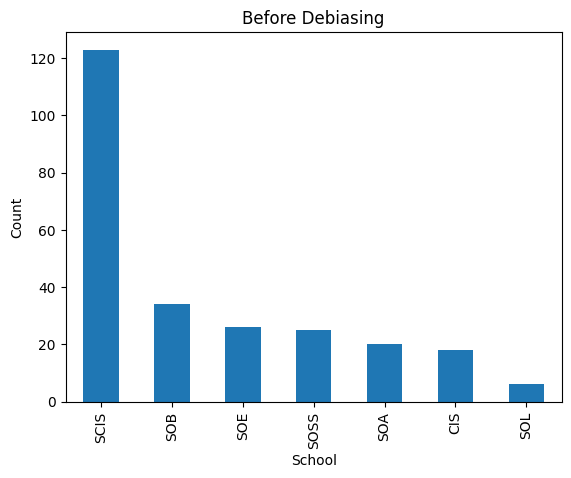

In [17]:
import matplotlib.pyplot as plt

# Plot the original distribution of schools in the dataset
df['School'].value_counts().plot(kind='bar', title="Before Debiasing")
plt.xlabel('School')
plt.ylabel('Count')
plt.show()



BEFORE DEBIASING - Baseline School Distribution

Raw sample distribution:
  SCIS: 123 students (48.8%)
  SOB: 34 students (13.5%)
  SOE: 26 students (10.3%)
  SOSS: 25 students (9.9%)
  SOA: 20 students (7.9%)
  CIS: 18 students (7.1%)
  SOL: 6 students (2.4%)

Total students: 252

⚠️ PROBLEM: Sample is skewed!
Without debiasing, the model learns mostly from over-represented schools.


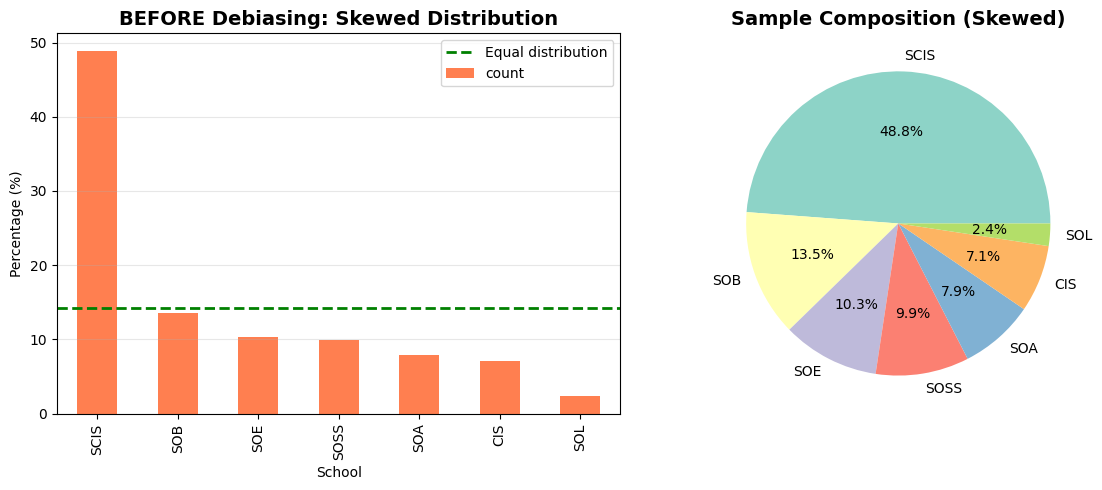


👆 See how unbalanced this is? Let's fix it with debiasing!


In [19]:
# ============================================
# PART A: BEFORE DEBIASING (BASELINE)
# ============================================

print("\n" + "="*60)
print("BEFORE DEBIASING - Baseline School Distribution")
print("="*60)

# Show the skewed distribution (SCIS over-represented)
school_dist = data['school'].value_counts()
school_pct = (school_dist / len(data) * 100).round(1)

print("\nRaw sample distribution:")
for school, count in school_dist.items():
    pct = school_pct[school]
    print(f"  {school}: {count} students ({pct}%)")

print(f"\nTotal students: {len(data)}")
print("\n⚠️ PROBLEM: Sample is skewed!")
print("Without debiasing, the model learns mostly from over-represented schools.")

# Visualize the skewed distribution
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Bar chart
school_pct.plot(kind='bar', ax=ax[0], color='coral')
ax[0].set_title('BEFORE Debiasing: Skewed Distribution', fontsize=14, fontweight='bold')
ax[0].set_ylabel('Percentage (%)')
ax[0].set_xlabel('School')
ax[0].axhline(y=100/len(school_dist), color='green', linestyle='--', 
              label='Equal distribution', linewidth=2)
ax[0].legend()
ax[0].grid(axis='y', alpha=0.3)

# Pie chart
school_dist.plot(kind='pie', ax=ax[1], autopct='%1.1f%%', colors=plt.cm.Set3.colors)
ax[1].set_title('Sample Composition (Skewed)', fontsize=14, fontweight='bold')
ax[1].set_ylabel('')

plt.tight_layout()
plt.show()

print("\n👆 See how unbalanced this is? Let's fix it with debiasing!")


In [21]:
# ============================================
# FIRST: CREATE TRAIN/VALID/TEST SPLITS  
# ============================================

from sklearn.model_selection import train_test_split
import pandas as pd

print("\n" + "="*60)
print("STEP 1: Creating Train/Valid/Test Splits")
print("="*60)

# Create target variable (likelihood to attend based on intent)
data['target'] = (data['intent_90d'] >= 7).astype(int)

print(f"\nTotal samples: {len(data)}")
print(f"Target distribution:")
print(f"  Likely to attend (y=1): {data['target'].sum()} ({data['target'].mean()*100:.1f}%)")
print(f"  Not likely (y=0): {(1-data['target']).sum()} ({(1-data['target']).mean()*100:.1f}%)")

# Stratified split: 70% train, 15% validation, 15% test
# This maintains school distribution across all splits
train_data, temp_data = train_test_split(
    data, 
    test_size=0.30,  # 30% for valid+test
    stratify=data['school'],  # <-- DEBIASING PART 1: Maintains proportions
    random_state=42
)

# Split temp into validation and test (50/50 = 15% each of total)
valid_data, test_data = train_test_split(
    temp_data,
    test_size=0.50,
    stratify=temp_data['school'],
    random_state=42
)

print(f"\nSplit sizes:")
print(f"  Train: {len(train_data)} ({len(train_data)/len(data)*100:.1f}%)")
print(f"  Valid: {len(valid_data)} ({len(valid_data)/len(data)*100:.1f}%)")
print(f"  Test:  {len(test_data)} ({len(test_data)/len(data)*100:.1f}%)")

# Verify stratification worked
print("\nSchool distribution maintained across splits:")
for split_name, split_df in [('Train', train_data), ('Valid', valid_data), ('Test', test_data)]:
    dist = split_df['school'].value_counts(normalize=True) * 100
    print(f"\n{split_name}:")
    for school, pct in dist.items():
        print(f"  {school}: {pct:.1f}%")

print("\n✅ Data split complete! Now ready for debiasing...")



STEP 1: Creating Train/Valid/Test Splits

Total samples: 252
Target distribution:
  Likely to attend (y=1): 62 (24.6%)
  Not likely (y=0): 190 (75.4%)

Split sizes:
  Train: 176 (69.8%)
  Valid: 38 (15.1%)
  Test:  38 (15.1%)

School distribution maintained across splits:

Train:
  SCIS: 48.9%
  SOB: 13.6%
  SOE: 10.2%
  SOSS: 9.7%
  SOA: 8.0%
  CIS: 7.4%
  SOL: 2.3%

Valid:
  SCIS: 50.0%
  SOB: 13.2%
  SOSS: 10.5%
  SOE: 10.5%
  SOA: 7.9%
  CIS: 5.3%
  SOL: 2.6%

Test:
  SCIS: 47.4%
  SOB: 13.2%
  SOE: 10.5%
  SOSS: 10.5%
  SOA: 7.9%
  CIS: 7.9%
  SOL: 2.6%

✅ Data split complete! Now ready for debiasing...


In [26]:
# ============================================
# PART B: DEBIASING WITH EQUAL DISTRIBUTION TARGET
# ============================================

print("\n" + "="*60)
print("APPLYING DEBIASING - Target: EQUAL Distribution")
print("="*60)

import pandas as pd
import numpy as np

def calculate_debiasing_weights_equal(df):
    """
    Calculate post-stratification weights to achieve EQUAL distribution.
    
    Target: All schools should have equal representation (1/n_schools each)
    Formula: weight = (1/n_schools) / sample_share
    
    This ensures the model learns EQUALLY from ALL schools!
    """
    # Get sample distribution (what we actually have)
    sample_dist = df['school'].value_counts(normalize=True)
    
    # Target distribution: EQUAL for all schools
    n_schools = len(sample_dist)
    target_share = 1.0 / n_schools  # Each school should be equal
    
    # Calculate weight for each student
    weights = pd.Series(index=df.index, dtype=float)
    
    print("\nWeight calculations (Target: Equal distribution):")
    print("-" * 60)
    print(f"Target per school: {target_share*100:.1f}% (equal representation)\n")
    
    for school in df['school'].unique():
        if pd.notna(school):
            sample_share = sample_dist.get(school, 0)
            
            if sample_share > 0:
                weight = target_share / sample_share
                weights[df['school'] == school] = weight
                
                effect = "⬇️ DOWNWEIGHT" if weight < 1 else "⬆️ UPWEIGHT"
                change = ((weight - 1.0) * 100)
                print(f"{school:10s}:")
                print(f"  Sample:      {sample_share*100:5.1f}%")
                print(f"  Target:      {target_share*100:5.1f}%")
                print(f"  → Weight:    {weight:.3f} {effect} ({change:+.1f}%)")
            else:
                weights[df['school'] == school] = 1.0
        else:
            weights[df['school'].isna()] = 1.0
    
    return weights

# Apply debiasing weights with EQUAL distribution target
print("\n" + "="*60)
print("Applying weights to train/valid/test splits...")
print("="*60)

train_data['sample_weight'] = calculate_debiasing_weights_equal(train_data)
valid_data['sample_weight'] = calculate_debiasing_weights_equal(valid_data)
test_data['sample_weight'] = calculate_debiasing_weights_equal(test_data)

print("\n✅ Debiasing weights successfully applied!")
print("\nWeight summary (training set):")
print("=" * 60)
weight_summary = train_data.groupby('school')['sample_weight'].first().sort_values()
for school, weight in weight_summary.items():
    bar = "█" * int(weight * 10)  # Adjusted scale
    effect = "⬇️" if weight < 1 else "⬆️"
    print(f"  {school:10s}: {weight:.3f} {effect} {bar}")

print("\n" + "=" * 60)
print("KEY INSIGHT:")
print("  Schools with > 14.3% sample → DOWNWEIGHTED")
print("  Schools with < 14.3% sample → UPWEIGHTED")
print("  Result: Model learns EQUALLY from all schools!")
print("=" * 60)



APPLYING DEBIASING - Target: EQUAL Distribution

Applying weights to train/valid/test splits...

Weight calculations (Target: Equal distribution):
------------------------------------------------------------
Target per school: 14.3% (equal representation)

SOSS      :
  Sample:        9.7%
  Target:       14.3%
  → Weight:    1.479 ⬆️ UPWEIGHT (+47.9%)
CIS       :
  Sample:        7.4%
  Target:       14.3%
  → Weight:    1.934 ⬆️ UPWEIGHT (+93.4%)
SCIS      :
  Sample:       48.9%
  Target:       14.3%
  → Weight:    0.292 ⬇️ DOWNWEIGHT (-70.8%)
SOE       :
  Sample:       10.2%
  Target:       14.3%
  → Weight:    1.397 ⬆️ UPWEIGHT (+39.7%)
SOB       :
  Sample:       13.6%
  Target:       14.3%
  → Weight:    1.048 ⬆️ UPWEIGHT (+4.8%)
SOA       :
  Sample:        8.0%
  Target:       14.3%
  → Weight:    1.796 ⬆️ UPWEIGHT (+79.6%)
SOL       :
  Sample:        2.3%
  Target:       14.3%
  → Weight:    6.286 ⬆️ UPWEIGHT (+528.6%)

Weight calculations (Target: Equal distribution):
---


Creating Before & After Debiasing Visualization


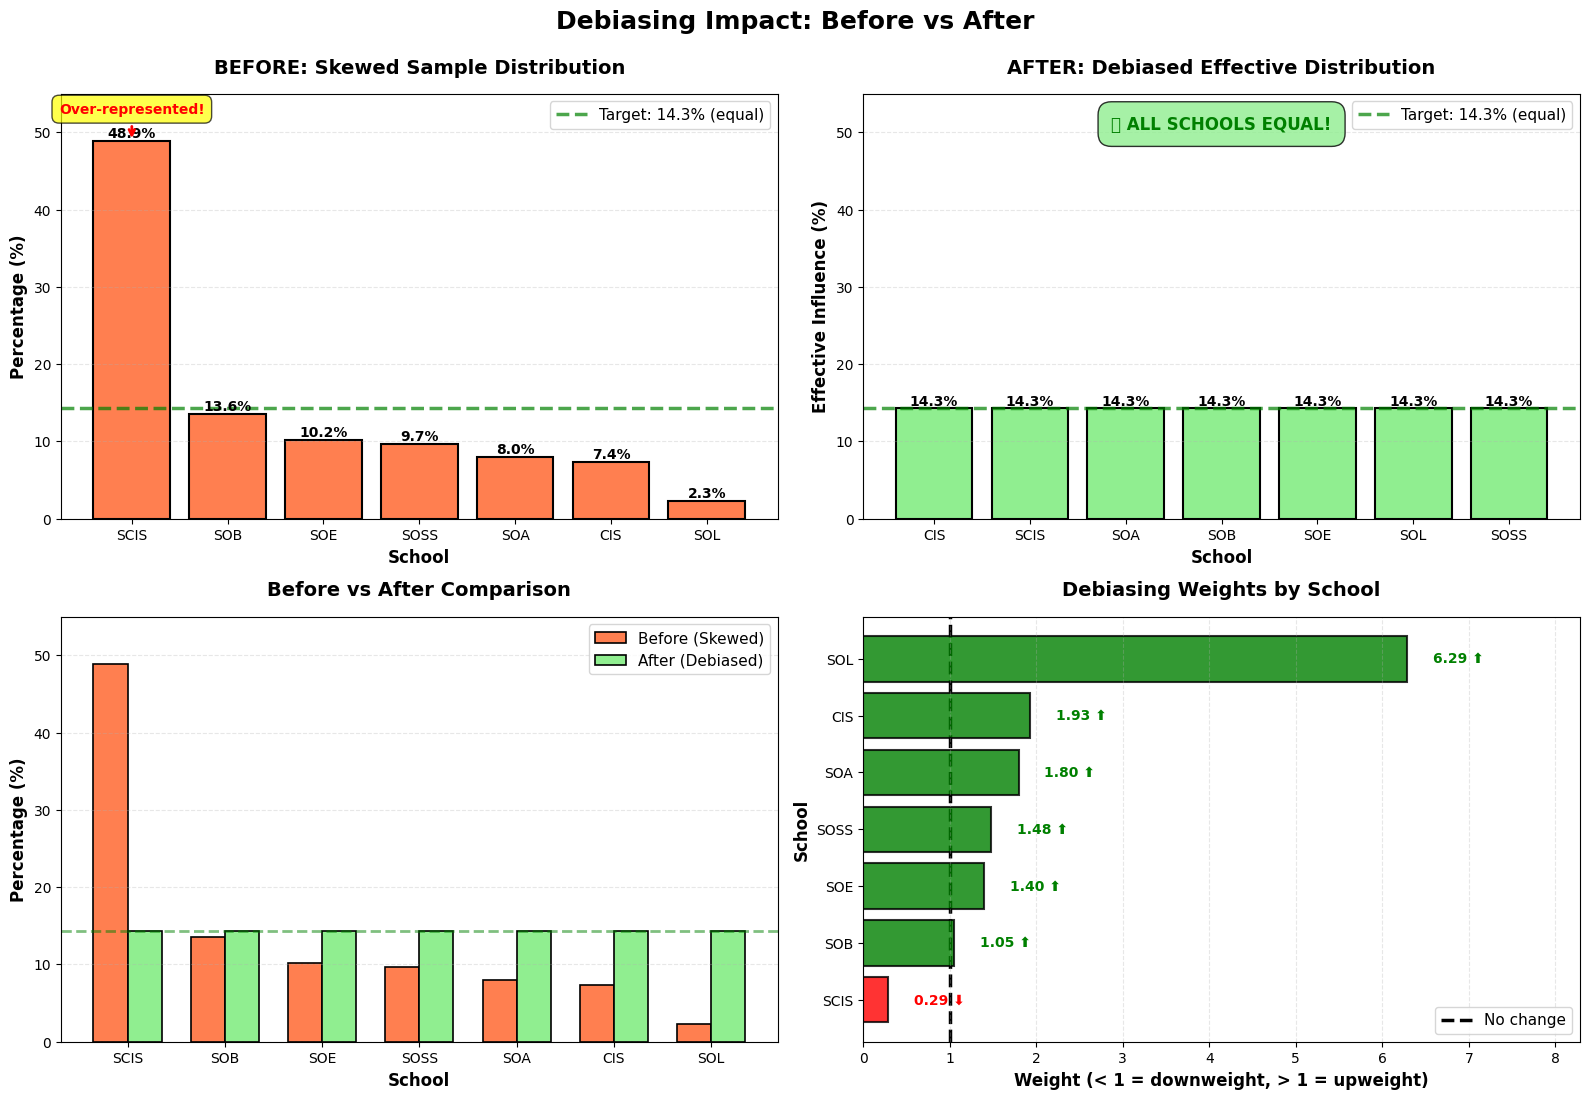


✅ Visualization complete!

Key Takeaways:
  BEFORE: SCIS dominated at 48.9%
  AFTER:  All schools equal at ~14.3%
  SCIS downweighted: 0.292x
  SOL upweighted:    6.286x


In [28]:
# ============================================
# BEFORE & AFTER VISUALIZATION
# ============================================

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print("\n" + "="*60)
print("Creating Before & After Debiasing Visualization")
print("="*60)

# BEFORE: Raw sample distribution
raw_dist = train_data['school'].value_counts()
raw_pct = (raw_dist / len(train_data) * 100).round(1)

# AFTER: Effective distribution (should all be ~14.3%)
effective_contributions = train_data.groupby('school')['sample_weight'].sum()
effective_pct = (effective_contributions / effective_contributions.sum() * 100).round(1)

# Target (equal distribution)
n_schools = len(raw_pct)
target_pct = 100.0 / n_schools

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 11))
fig.suptitle('Debiasing Impact: Before vs After', fontsize=18, fontweight='bold', y=0.995)

# ============================================
# Chart 1: BEFORE (Top Left)
# ============================================
ax1 = axes[0, 0]
bars1 = ax1.bar(raw_pct.index, raw_pct.values, color='coral', edgecolor='black', linewidth=1.5)
ax1.set_title('BEFORE: Skewed Sample Distribution', fontsize=14, fontweight='bold', pad=15)
ax1.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
ax1.set_xlabel('School', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_ylim(0, 55)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add target line
ax1.axhline(y=target_pct, color='green', linestyle='--', linewidth=2.5, 
            label=f'Target: {target_pct:.1f}% (equal)', alpha=0.7)
ax1.legend(fontsize=11, loc='upper right')

# Add annotation for SCIS
scis_bar = bars1[list(raw_pct.index).index('SCIS')]
ax1.annotate('Over-represented!', 
            xy=(scis_bar.get_x() + scis_bar.get_width()/2, scis_bar.get_height()),
            xytext=(0, 20), textcoords='offset points',
            ha='center', fontsize=10, color='red', fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
            arrowprops=dict(arrowstyle='->', color='red', lw=2))

# ============================================
# Chart 2: AFTER (Top Right)
# ============================================
ax2 = axes[0, 1]
bars2 = ax2.bar(effective_pct.index, effective_pct.values, 
                color='lightgreen', edgecolor='black', linewidth=1.5)
ax2.set_title('AFTER: Debiased Effective Distribution', fontsize=14, fontweight='bold', pad=15)
ax2.set_ylabel('Effective Influence (%)', fontsize=12, fontweight='bold')
ax2.set_xlabel('School', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_ylim(0, 55)

# Add value labels on bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add target line
ax2.axhline(y=target_pct, color='green', linestyle='--', linewidth=2.5, 
            label=f'Target: {target_pct:.1f}% (equal)', alpha=0.7)
ax2.legend(fontsize=11, loc='upper right')

# Add success annotation
ax2.text(0.5, 0.95, '✅ ALL SCHOOLS EQUAL!', 
        transform=ax2.transAxes, ha='center', va='top',
        fontsize=12, fontweight='bold', color='green',
        bbox=dict(boxstyle='round,pad=0.8', facecolor='lightgreen', alpha=0.8))

# ============================================
# Chart 3: Side-by-Side Comparison (Bottom Left)
# ============================================
ax3 = axes[1, 0]
comparison_df = pd.DataFrame({
    'Before (Skewed)': raw_pct,
    'After (Debiased)': effective_pct
}).sort_values('Before (Skewed)', ascending=False)

x = np.arange(len(comparison_df))
width = 0.35

bars_before = ax3.bar(x - width/2, comparison_df['Before (Skewed)'], width, 
                      label='Before (Skewed)', color='coral', edgecolor='black', linewidth=1.2)
bars_after = ax3.bar(x + width/2, comparison_df['After (Debiased)'], width, 
                     label='After (Debiased)', color='lightgreen', edgecolor='black', linewidth=1.2)

ax3.set_title('Before vs After Comparison', fontsize=14, fontweight='bold', pad=15)
ax3.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
ax3.set_xlabel('School', fontsize=12, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(comparison_df.index, rotation=0)
ax3.legend(fontsize=11, loc='upper right')
ax3.grid(axis='y', alpha=0.3, linestyle='--')
ax3.axhline(y=target_pct, color='green', linestyle='--', linewidth=2, alpha=0.5)
ax3.set_ylim(0, 55)

# ============================================
# Chart 4: Debiasing Weights (Bottom Right)
# ============================================
ax4 = axes[1, 1]
weights_plot = train_data.groupby('school')['sample_weight'].first().sort_values()
colors = ['red' if w < 1 else 'green' for w in weights_plot.values]
bars4 = ax4.barh(weights_plot.index, weights_plot.values, color=colors, 
                 edgecolor='black', linewidth=1.5, alpha=0.8)

ax4.set_title('Debiasing Weights by School', fontsize=14, fontweight='bold', pad=15)
ax4.set_xlabel('Weight (< 1 = downweight, > 1 = upweight)', fontsize=12, fontweight='bold')
ax4.set_ylabel('School', fontsize=12, fontweight='bold')
ax4.axvline(x=1.0, color='black', linestyle='--', linewidth=2.5, label='No change', zorder=0)
ax4.legend(fontsize=11, loc='lower right')
ax4.grid(axis='x', alpha=0.3, linestyle='--')

# Add value labels
for i, (school, weight) in enumerate(weights_plot.items()):
    label = f'{weight:.2f}'
    if weight < 1:
        label += ' ⬇️'
        color = 'red'
    else:
        label += ' ⬆️'
        color = 'green'
    ax4.text(weight + 0.3, i, label, va='center', fontsize=10, 
            fontweight='bold', color=color)

# Set x-axis limits to accommodate labels
ax4.set_xlim(0, max(weights_plot.values) + 2)

plt.tight_layout()
plt.savefig('debiasing_before_after.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualization complete!")
print("\nKey Takeaways:")
print("=" * 60)
print(f"  BEFORE: SCIS dominated at {raw_pct.get('SCIS', 0):.1f}%")
print(f"  AFTER:  All schools equal at ~{target_pct:.1f}%")
print(f"  SCIS downweighted: {weights_plot.get('SCIS', 0):.3f}x")
print(f"  SOL upweighted:    {weights_plot.get('SOL', 0):.3f}x")
print("=" * 60)


In [36]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score

# 1. Data Cleaning: Convert ranges/strings to numbers for numeric columns
def range_to_float(x):
    if isinstance(x, str) and '-' in x:
        a, b = x.split('-')
        return (float(a) + float(b)) / 2
    try:
        return float(x)
    except:
        return np.nan

def year_to_int(x):
    if isinstance(x, str):
        import re
        m = re.search(r'\d+', x)
        if m:
            return int(m.group())
        return np.nan
    return x

for df in [train_data, valid_data, test_data]:
    df['past_attend_count'] = df['past_attend_count'].apply(range_to_float)
    df['no_show_count'] = df['no_show_count'].apply(range_to_float)
    df['year'] = df['year'].apply(year_to_int)
    df['age'] = pd.to_numeric(df['age'], errors='coerce')  # In case age has similar issues

# 2. Features/Target (copy from your columns exactly)
FEATURES = [
    'intent_90d', 'past_attend_count', 'no_show_count',
    'next_program', 'preferred_format', 'preferred_time_windows',
    'barrier_time', 'barrier_cost', 'barrier_motivation', 'barrier_access',
    'relevance_MHW', 'relevance_Resilience', 'relevance_ExamAngels', 'relevance_SCS',
    'relevance_CosyHaven', 'relevance_Voices', 'relevance_PeerHelpers',
    'relevance_CareerCompass', 'relevance_CARES',
    'school', 'age', 'gender', 'year'
]
TARGET = 'target'

numeric_features = [
    'intent_90d', 'past_attend_count', 'no_show_count', 'age', 'year',
    'relevance_MHW', 'relevance_Resilience', 'relevance_ExamAngels', 'relevance_SCS',
    'relevance_CosyHaven', 'relevance_Voices', 'relevance_PeerHelpers',
    'relevance_CareerCompass', 'relevance_CARES'
]
categorical_features = [
    'next_program', 'preferred_format', 'preferred_time_windows',
    'barrier_time', 'barrier_cost', 'barrier_motivation', 'barrier_access',
    'school', 'gender'
]

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

# 3. Prepare data
X_train = train_data[FEATURES]
y_train = train_data[TARGET]
w_train = train_data["sample_weight"]
X_valid = valid_data[FEATURES]
y_valid = valid_data[TARGET]
w_valid = valid_data["sample_weight"]

# 4. Build and fit pipeline
baseline_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42))
])
baseline_pipe.fit(X_train, y_train, clf__sample_weight=w_train)

# 5. Predict and evaluate
y_pred_valid = baseline_pipe.predict(X_valid)
y_prob_valid = baseline_pipe.predict_proba(X_valid)[:, 1]
print("ROC-AUC:", roc_auc_score(y_valid, y_prob_valid, sample_weight=w_valid))
print("F1 Score:", f1_score(y_valid, y_pred_valid, sample_weight=w_valid))


ROC-AUC: 0.9984064585582308
F1 Score: 0.9821640903686086


In [37]:
X_test = test_data[FEATURES]
y_test = test_data[TARGET]
w_test = test_data["sample_weight"]


In [38]:
y_pred_test = baseline_pipe.predict(X_test)
y_prob_test = baseline_pipe.predict_proba(X_test)[:, 1]


In [39]:
print("Test ROC-AUC:", roc_auc_score(y_test, y_prob_test, sample_weight=w_test))
print("Test F1 Score:", f1_score(y_test, y_pred_test, sample_weight=w_test))


Test ROC-AUC: 0.9981068494188028
Test F1 Score: 0.9778761061946902


In [44]:
def range_to_float(x):
    if isinstance(x, str) and '-' in x:
        a, b = x.split('-')
        return (float(a) + float(b)) / 2
    try:
        return float(x)
    except:
        return np.nan

def year_to_int(x):
    if isinstance(x, str):
        import re
        m = re.search(r'\d+', x)
        if m:
            return int(m.group())
        return np.nan
    return x

# Apply to data DataFrame BEFORE extracting features for prediction:
for col in ['past_attend_count', 'no_show_count']:
    data[col] = data[col].apply(range_to_float)
data['year'] = data['year'].apply(year_to_int)
data['age'] = pd.to_numeric(data['age'], errors='coerce')


X_all = data[FEATURES]
p_attend = baseline_pipe.predict_proba(X_all)[:, 1]
attend_pred = baseline_pipe.predict(X_all)
data['p_attend'] = p_attend
data['attend_pred'] = attend_pred


In [45]:
import numpy as np
import pandas as pd

# --- CLEANING: make sure these match your earlier usage ---
def range_to_float(x):
    if isinstance(x, str) and '-' in x:
        a, b = x.split('-')
        return (float(a) + float(b)) / 2
    try:
        return float(x)
    except:
        return np.nan

def year_to_int(x):
    if isinstance(x, str):
        import re
        m = re.search(r'\d+', x)
        if m:
            return int(m.group())
        return np.nan
    return x

# Apply to your survey DataFrame (assume it's called 'data')
for col in ['past_attend_count', 'no_show_count']:
    data[col] = data[col].apply(range_to_float)
data['year'] = data['year'].apply(year_to_int)
data['age'] = pd.to_numeric(data['age'], errors='coerce')

# --- PREDICTION: grab random rows and predict ---
SAMPLE = data.sample(n=5, random_state=42)         # Take 5 random students

X_sample = SAMPLE[FEATURES]                        # Extract feature columns
probs = baseline_pipe.predict_proba(X_sample)[:,1] # Predicted probability to attend
attend_pred = baseline_pipe.predict(X_sample)      # 0/1 predicted attendance

SAMPLE = SAMPLE.copy()                             # Attach result columns
SAMPLE['predicted_attendance_prob'] = probs        # Probability output (0.0-1.0)
SAMPLE['predicted_attend'] = attend_pred           # 1 = attend, 0 = not attend

print(SAMPLE[['predicted_attendance_prob', 'predicted_attend'] + FEATURES])


     predicted_attendance_prob  predicted_attend  intent_90d  \
165                   0.000841                 0           0   
6                     0.041718                 0           3   
111                   0.906593                 1          10   
172                   0.081565                 0           5   
115                   0.003854                 0           0   

     past_attend_count  no_show_count             next_program  \
165                1.0            0.0  Nutrition/meal planning   
6                  0.0            0.0       Financial wellness   
111                0.0            0.0       Peer support group   
172                2.5            1.0       Financial wellness   
115                0.0            0.0     Mental health skills   

         preferred_format            preferred_time_windows  barrier_time  \
165       In-person group                   Weekday evening            10   
6         In-person group                   Weekday evening     

In [31]:
print(train_data.columns)


Index(['age', 'gender', 'year', 'school', 'intent_90d', 'past_attend_count',
       'no_show_count', 'next_program', 'preferred_format',
       'preferred_time_windows', 'barrier_time', 'barrier_cost',
       'barrier_motivation', 'barrier_access', 'relevance_MHW',
       'relevance_Resilience', 'relevance_ExamAngels', 'relevance_SCS',
       'relevance_CosyHaven', 'relevance_Voices', 'relevance_PeerHelpers',
       'relevance_CareerCompass', 'relevance_CARES', 'target',
       'sample_weight'],
      dtype='object')
